# Introduction
The primary goal of this project is to analyze and model the news articles dataset that contain released articles both fake and real ones to be able to develop a predictive system that can predict whether a new article is fake or real.

In [ ]:
# nltk.download('opinion_lexicon')
# nltk.download('punkt')

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# Data Prep

1. Importing datasets
2. Labeling the columns before merging the datasets to classify (0=>fake, 1=>real)
3. Merging into one dataset

In [2]:
fake_news = pd.read_csv("fake.csv", sep= ",")
fake_news.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
real_news = pd.read_csv("true.csv", sep=",")
real_news.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news["label"] = 0
real_news["label"] = 1
# real_news.head(5)

In [5]:
print("fake news shape:",fake_news.shape)
print("Real news shape:",real_news.shape)

fake news shape: (23481, 5)
Real news shape: (21417, 5)


In [6]:
data = pd.concat([fake_news,real_news]).sample(frac=1, random_state=45, ignore_index=True)
data.head(5)

,title,text,subject,date,label
0,Online bettors see Donald Trump as odds-on Rep...,NEW YORK/LONDON (Reuters) - Donald Trump’s cha...,politicsNews,"February 24, 2016",1
1,WATCH: Violent Trump Fan Shoves Peaceful Prot...,The violence and hate we witnessed at Trump ra...,News,"November 14, 2016",0
2,ILLEGAL ALIENS Jump Over Border Fence as MSNBC...,Oh the irony! Left-leaning MSNBC aired a segme...,Government News,"Oct 23, 2017",0
3,Lockheed says didn't seek help from Trump's ex...,(Reuters) - Lockheed Martin Corp (LMT.N) did n...,politicsNews,"February 3, 2017",1
4,"Thanks, Obama: A Tribute To My Great President","Thank you, President Obama.In 2004, during the...",News,"January 11, 2017",0


# Preprocessing

In [7]:
data.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [8]:
data['date'] = pd.to_datetime(data['date'], format='mixed', errors='coerce')
data.dtypes

title              object
text               object
subject            object
date       datetime64[ns]
label               int64
dtype: object

In [9]:
print(data.shape)

(44898, 5)


In [10]:
# Check for empty strings
data[['title', 'text', 'subject']].apply(lambda col:col.str.strip().eq('').sum())

title        0
text       631
subject      0
dtype: int64

In [11]:
data[['title', 'text', 'subject']] = data[['title', 'text', 'subject']].replace(r'^\s*$', np.nan, regex=True)

In [12]:
data.isnull().sum()

title        0
text       631
subject      0
date        10
label        0
dtype: int64

In [13]:
data=data.dropna()

In [14]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [15]:
print(data.shape)

(44257, 5)


In [16]:
print(data.duplicated().sum())

209


In [17]:
data = data.drop_duplicates()
print(data.shape)

(44048, 5)


In [18]:
data.reset_index(drop=True, inplace=True)
data.head(5)

,title,text,subject,date,label
0,Online bettors see Donald Trump as odds-on Rep...,NEW YORK/LONDON (Reuters) - Donald Trump’s cha...,politicsNews,2016-02-24,1
1,WATCH: Violent Trump Fan Shoves Peaceful Prot...,The violence and hate we witnessed at Trump ra...,News,2016-11-14,0
2,ILLEGAL ALIENS Jump Over Border Fence as MSNBC...,Oh the irony! Left-leaning MSNBC aired a segme...,Government News,2017-10-23,0
3,Lockheed says didn't seek help from Trump's ex...,(Reuters) - Lockheed Martin Corp (LMT.N) did n...,politicsNews,2017-02-03,1
4,"Thanks, Obama: A Tribute To My Great President","Thank you, President Obama.In 2004, during the...",News,2017-01-11,0


- Cleaning the text using Regex , removing stopwords, and leminizing the textual features to get rid of anything that may create noise to the data

In [19]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)
    # keeps only alphabets ,and spaces for clarity
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]

    text = ' '.join(lemmatized_words)
    
    return text

In [20]:
data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_title'] = data['title'].apply(clean_text)
data['cleaned_subject'] = data['subject'].apply(clean_text)

In [21]:
data.head(5)

,title,text,subject,date,label,cleaned_text,cleaned_title,cleaned_subject
0,Online bettors see Donald Trump as odds-on Rep...,NEW YORK/LONDON (Reuters) - Donald Trump’s cha...,politicsNews,2016-02-24,1,new yorklondon reuters donald trump chance win...,online bettor see donald trump oddson republic...,politicsnews
1,WATCH: Violent Trump Fan Shoves Peaceful Prot...,The violence and hate we witnessed at Trump ra...,News,2016-11-14,0,violence hate witnessed trump rally spilling r...,watch violent trump fan shove peaceful protest...,news
2,ILLEGAL ALIENS Jump Over Border Fence as MSNBC...,Oh the irony! Left-leaning MSNBC aired a segme...,Government News,2017-10-23,0,oh irony leftleaning msnbc aired segment presi...,illegal alien jump border fence msnbc report b...,government news
3,Lockheed says didn't seek help from Trump's ex...,(Reuters) - Lockheed Martin Corp (LMT.N) did n...,politicsNews,2017-02-03,1,reuters lockheed martin corp lmtn turn corey l...,lockheed say didnt seek help trump excampaign ...,politicsnews
4,"Thanks, Obama: A Tribute To My Great President","Thank you, President Obama.In 2004, during the...",News,2017-01-11,0,thank president obamain democratic national co...,thanks obama tribute great president,news


- Check unique words in subject column to remove redundancies

In [22]:
data['cleaned_subject'].unique()

array(['politicsnews', 'news', 'government news', 'politics', 'worldnews',
       'leftnews', 'usnews', 'middleeast'], dtype=object)

In [23]:
data['cleaned_subject'] = data['cleaned_subject'].replace({'politics': 'politicsnews',
                                                           'news': 'generalnews',
                                                           'government news':'governmentnews'})

In [24]:
data['cleaned_subject'].unique()

array(['politicsnews', 'generalnews', 'governmentnews', 'worldnews',
       'leftnews', 'usnews', 'middleeast'], dtype=object)

In [43]:
clean_data=pd.DataFrame()
clean_data[['title', 'subject', 'article', 'date', 'label']]=data[['cleaned_title','cleaned_subject','cleaned_text', 'date', 'label']]
clean_data.head(5)

,title,subject,article,date,label
0,online bettor see donald trump oddson republic...,politicsnews,new yorklondon reuters donald trump chance win...,2016-02-24,1
1,watch violent trump fan shove peaceful protest...,generalnews,violence hate witnessed trump rally spilling r...,2016-11-14,0
2,illegal alien jump border fence msnbc report b...,governmentnews,oh irony leftleaning msnbc aired segment presi...,2017-10-23,0
3,lockheed say didnt seek help trump excampaign ...,politicsnews,reuters lockheed martin corp lmtn turn corey l...,2017-02-03,1
4,thanks obama tribute great president,generalnews,thank president obamain democratic national co...,2017-01-11,0


# Exploratory Data Analysis and Feuture Engineering

In [44]:
clean_data.columns

Index(['title', 'subject', 'article', 'date', 'label'], dtype='object')

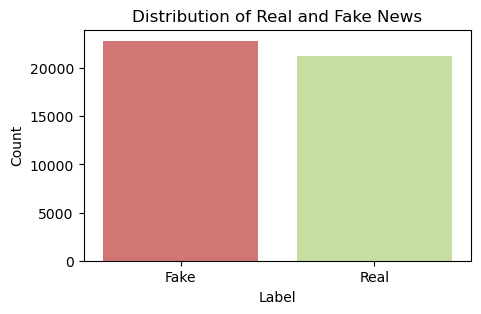

In [27]:
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=clean_data, palette=['#E06666', '#C9E798'])  
plt.title('Distribution of Real and Fake News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

- Graph shows distribution of fake and real news, Data is balanced

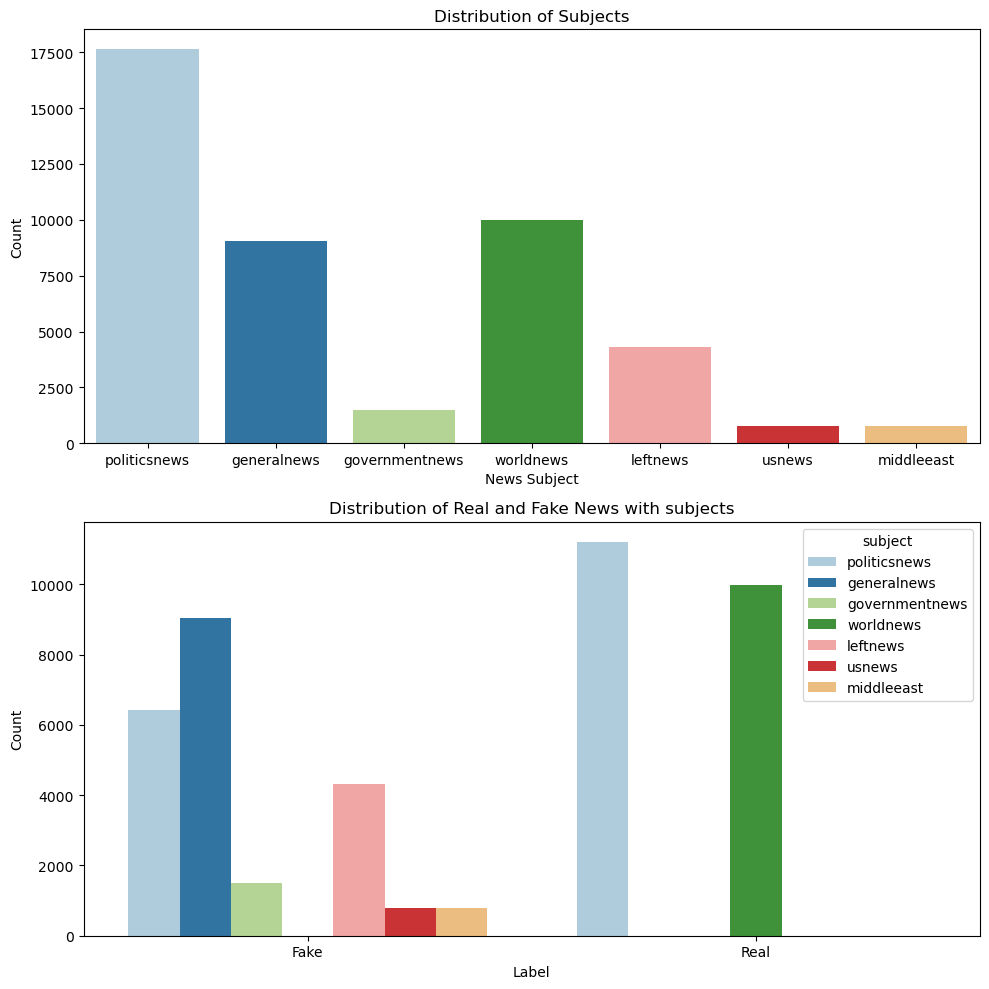

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.countplot(x='subject', data=clean_data, palette='Paired', ax=axes[0])
axes[0].set_title('Distribution of Subjects')
axes[0].set_xlabel('News Subject')
axes[0].set_ylabel('Count')

sns.countplot(x='label', hue='subject', data=clean_data, palette='Paired', ax=axes[1])
axes[1].set_title('Distribution of Real and Fake News with subjects')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Fake', 'Real'])

plt.tight_layout()

plt.show()

- It appears that the data consists mostly of politics news
- The data doesn't contain much government news
- without knowing what sort of news are the general, us ,left, Middle East news we can't say that the data is based on politics

- Real news only come from world and political news
- Fake news doesn’t come from world news
- Most of fake news come from general news

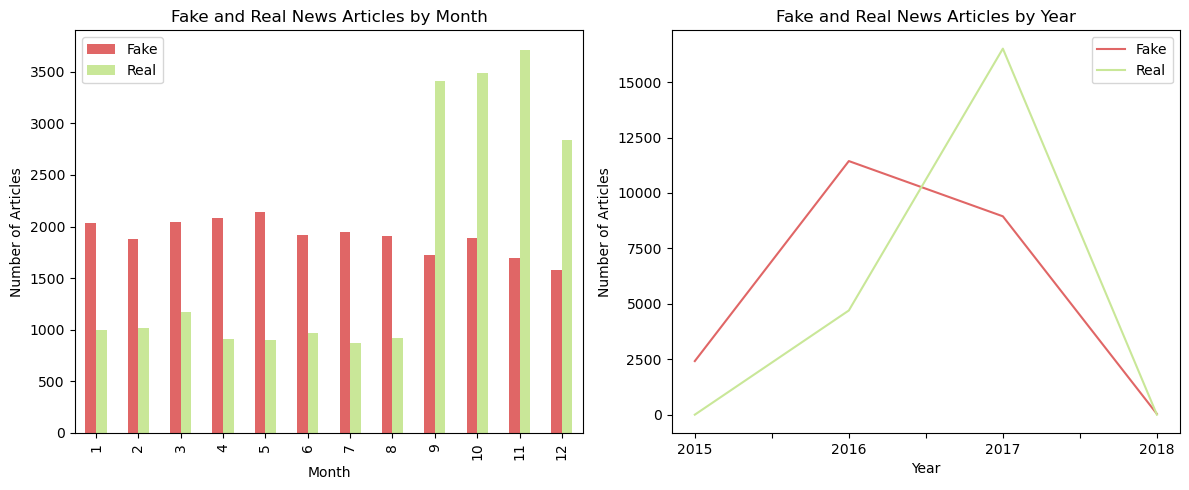

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

clean_data.groupby([clean_data['date'].dt.month, 'label']).size().unstack(fill_value=0).plot(kind='bar', color=['#E06666', '#C9E798'], ax=axes[0])
axes[0].set_title('Fake and Real News Articles by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Articles')
axes[0].legend(['Fake', 'Real'])

clean_data.groupby([clean_data['date'].dt.year.astype(str), 'label']).size().unstack(fill_value=0).plot(kind='line', color=['#E06666', '#C9E798'], ax=axes[1])
axes[1].set_title('Fake and Real News Articles by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Articles')
axes[1].legend(['Fake', 'Real'])

plt.tight_layout()
plt.show()

- The data contains articles from 2015 to 2018
- 2017 was the year with most articles released
- In 2017 the real articles published were double the fake ones
- in 2015 and 2018 only fake articles were published

- Articles tend to be Published more in the last months of the year
- October had the most Articles published

- Creating new features positive & negative word counts using opinion lexicon library (these features will be used in ML)

In [45]:
textual_data= ['title','subject','article']

In [46]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def count_sentiments(row):
    text = ' '.join(map(str, row))  
    words = word_tokenize(text)   
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)
    return positive_count, negative_count
    
clean_data[['positive_count', 'negative_count']] = clean_data[textual_data].apply(
    lambda row: pd.Series(count_sentiments(row)), axis=1
)

In [47]:
clean_data.head(5)

,title,subject,article,date,label,positive_count,negative_count
0,online bettor see donald trump oddson republic...,politicsnews,new yorklondon reuters donald trump chance win...,2016-02-24,1,17,7
1,watch violent trump fan shove peaceful protest...,generalnews,violence hate witnessed trump rally spilling r...,2016-11-14,0,17,20
2,illegal alien jump border fence msnbc report b...,governmentnews,oh irony leftleaning msnbc aired segment presi...,2017-10-23,0,12,29
3,lockheed say didnt seek help trump excampaign ...,politicsnews,reuters lockheed martin corp lmtn turn corey l...,2017-02-03,1,10,5
4,thanks obama tribute great president,generalnews,thank president obamain democratic national co...,2017-01-11,0,47,21


In [48]:
# Records with positive words
positive_reviews = clean_data[clean_data['positive_count'] > 0]

# Records with negative words
negative_reviews = clean_data[clean_data['negative_count'] > 0]

# Records with neither positive nor negative words
neutral_reviews = clean_data[(clean_data['positive_count'] == 0) & (clean_data['negative_count'] == 0)]

print(f"positive_reviews: {len(positive_reviews)}")
print(f"negative_reviews: {len(negative_reviews)}")
print(f"neutral_reviews: {len(neutral_reviews)}")

positive_reviews: 42454
negative_reviews: 42190
neutral_reviews: 313


In [49]:
clean_data.head(5)

,title,subject,article,date,label,positive_count,negative_count
0,online bettor see donald trump oddson republic...,politicsnews,new yorklondon reuters donald trump chance win...,2016-02-24,1,17,7
1,watch violent trump fan shove peaceful protest...,generalnews,violence hate witnessed trump rally spilling r...,2016-11-14,0,17,20
2,illegal alien jump border fence msnbc report b...,governmentnews,oh irony leftleaning msnbc aired segment presi...,2017-10-23,0,12,29
3,lockheed say didnt seek help trump excampaign ...,politicsnews,reuters lockheed martin corp lmtn turn corey l...,2017-02-03,1,10,5
4,thanks obama tribute great president,generalnews,thank president obamain democratic national co...,2017-01-11,0,47,21


- Creating a sentiment feature to visualize

In [59]:
def categorize_sentiment(row):
    if row['positive_count'] > row['negative_count']:
        return 'positive'
    elif row['positive_count'] < row['negative_count']:
        return 'negative'
    else:
        return 'neutral'

In [60]:
clean_data['sentiment'] = clean_data.apply(categorize_sentiment, axis=1) 
clean_data['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

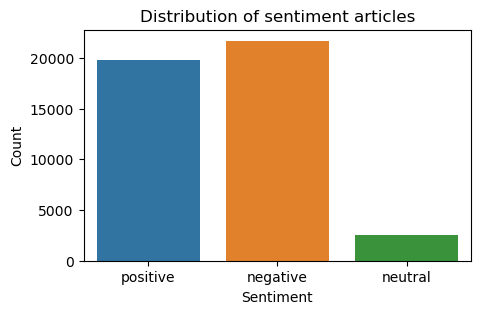

In [61]:
plt.figure(figsize=(5, 3))
sns.countplot(x='sentiment', data=clean_data)  
plt.title('Distribution of sentiment articles')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

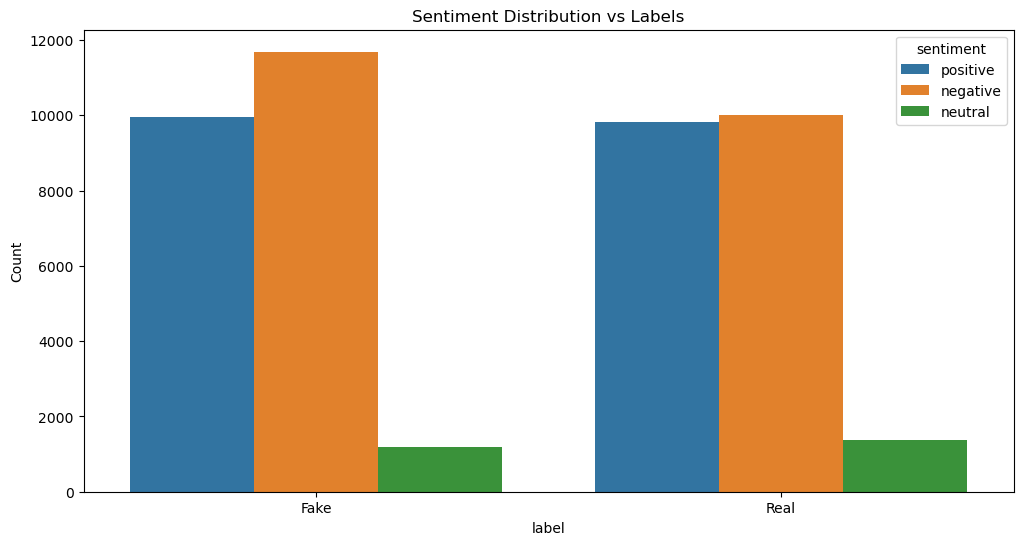

In [62]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', hue='sentiment', data=clean_data)
plt.title('Sentiment Distribution vs Labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

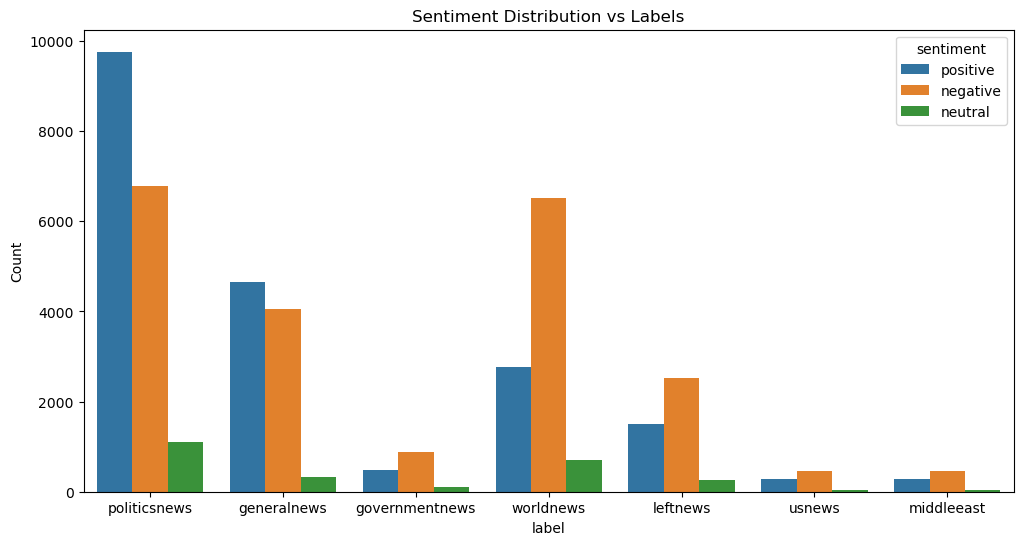

In [63]:
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', hue='sentiment', data=clean_data)
plt.title('Sentiment Distribution vs Labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

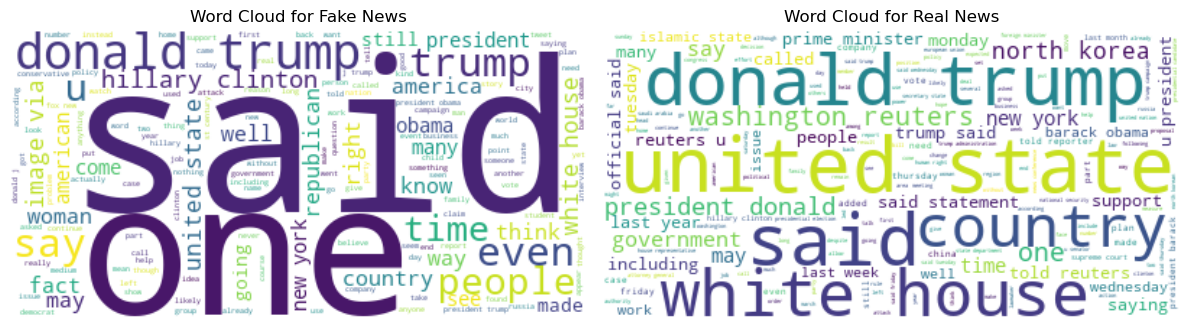

In [55]:
fake_news = clean_data[clean_data['label'] == 0]
real_news = clean_data[clean_data['label'] == 1]

fake_text = ' '.join(fake_news['article'])
real_text = ' '.join(real_news['article'])

wordcloud_fake = WordCloud(width=400, height=200, background_color='white').generate(fake_text)
wordcloud_real = WordCloud(width=400, height=200, background_color='white').generate(real_text)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News')

plt.tight_layout()
plt.show()

- Showcases the words mostly repeated in both fake and real articles
- Since the data mostly contains of political news the words mostly repeated are related to politics (Trump, donald trump, white house, republican,...)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [33]:
X = clean_data['article']
y = clean_data['label']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
process = Pipeline([
    ('vectorizer', TfidfVectorizer())
])

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Machine Learning

In [56]:
clean_data.shape

(44048, 8)

In [57]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer

TfidfVectorizer(max_features=10000)

In [58]:
def gridSearch(model, param, x_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
def Report(model_name,y_train,y_pred_train, y_test,y_pred_test):
    print(f"Classification Report For {model_name}:")
    print("1-For Train Data:")
    print("a-Accuracy Score:",accuracy_score(y_train, y_pred_train))
    print("b-MSE: ",mean_squared_error(y_train,y_pred_train))
    print(classification_report(y_train, y_pred_train))
    print("---------------------")
    print("2-For Test Data:")
    print("a-Accuracy Score:",accuracy_score(y_test, y_pred_test))
    print("b-MSE: ",mean_squared_error(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))

In [29]:
X = clean_data['article']
y = clean_data['label']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=45)

In [ ]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [30]:
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

LogisticRegression()

In [31]:
y_pred_reg = model.predict(X_test_tfidf)
print(classification_report(Y_test, y_pred_reg))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_reg))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4617
           1       0.99      0.99      0.99      4193

    accuracy                           0.99      8810
   macro avg       0.99      0.99      0.99      8810
weighted avg       0.99      0.99      0.99      8810

a-Accuracy Score: 0.987627695800227


In [32]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, Y_train)

MultinomialNB()

In [33]:
# Predictions
y_pred_mnb = mnb.predict(X_test_tfidf)
# Evaluation
print(classification_report(Y_test, y_pred_mnb))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4617
           1       0.93      0.93      0.93      4193

    accuracy                           0.93      8810
   macro avg       0.93      0.93      0.93      8810
weighted avg       0.93      0.93      0.93      8810

a-Accuracy Score: 0.9312145289443814


In [34]:
bnb = BernoulliNB()
bnb.fit(X_train_tfidf, Y_train)

BernoulliNB()

In [35]:
y_pred_bnb = bnb.predict(X_test_tfidf)
print(classification_report(Y_test, y_pred_bnb))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_bnb))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4617
           1       0.96      0.97      0.96      4193

    accuracy                           0.96      8810
   macro avg       0.96      0.96      0.96      8810
weighted avg       0.96      0.96      0.96      8810

a-Accuracy Score: 0.963677639046538


In [37]:
gb = HistGradientBoostingClassifier()
gb.fit(X_train_tfidf.toarray(), Y_train)

HistGradientBoostingClassifier()

In [38]:
y_pred_gb = gb.predict(X_test_tfidf.toarray())
print(classification_report(Y_test, y_pred_gb))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4617
           1       1.00      1.00      1.00      4193

    accuracy                           1.00      8810
   macro avg       1.00      1.00      1.00      8810
weighted avg       1.00      1.00      1.00      8810

a-Accuracy Score: 0.9971623155505108


In [39]:
rf = RandomForestClassifier(random_state=45)
rf.fit(X_train_tfidf, Y_train)

RandomForestClassifier(random_state=45)

In [40]:
y_pred_rf= rf.predict(X_test_tfidf)
print(classification_report(Y_test, y_pred_rf))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4617
           1       1.00      1.00      1.00      4193

    accuracy                           1.00      8810
   macro avg       1.00      1.00      1.00      8810
weighted avg       1.00      1.00      1.00      8810

a-Accuracy Score: 0.9971623155505108


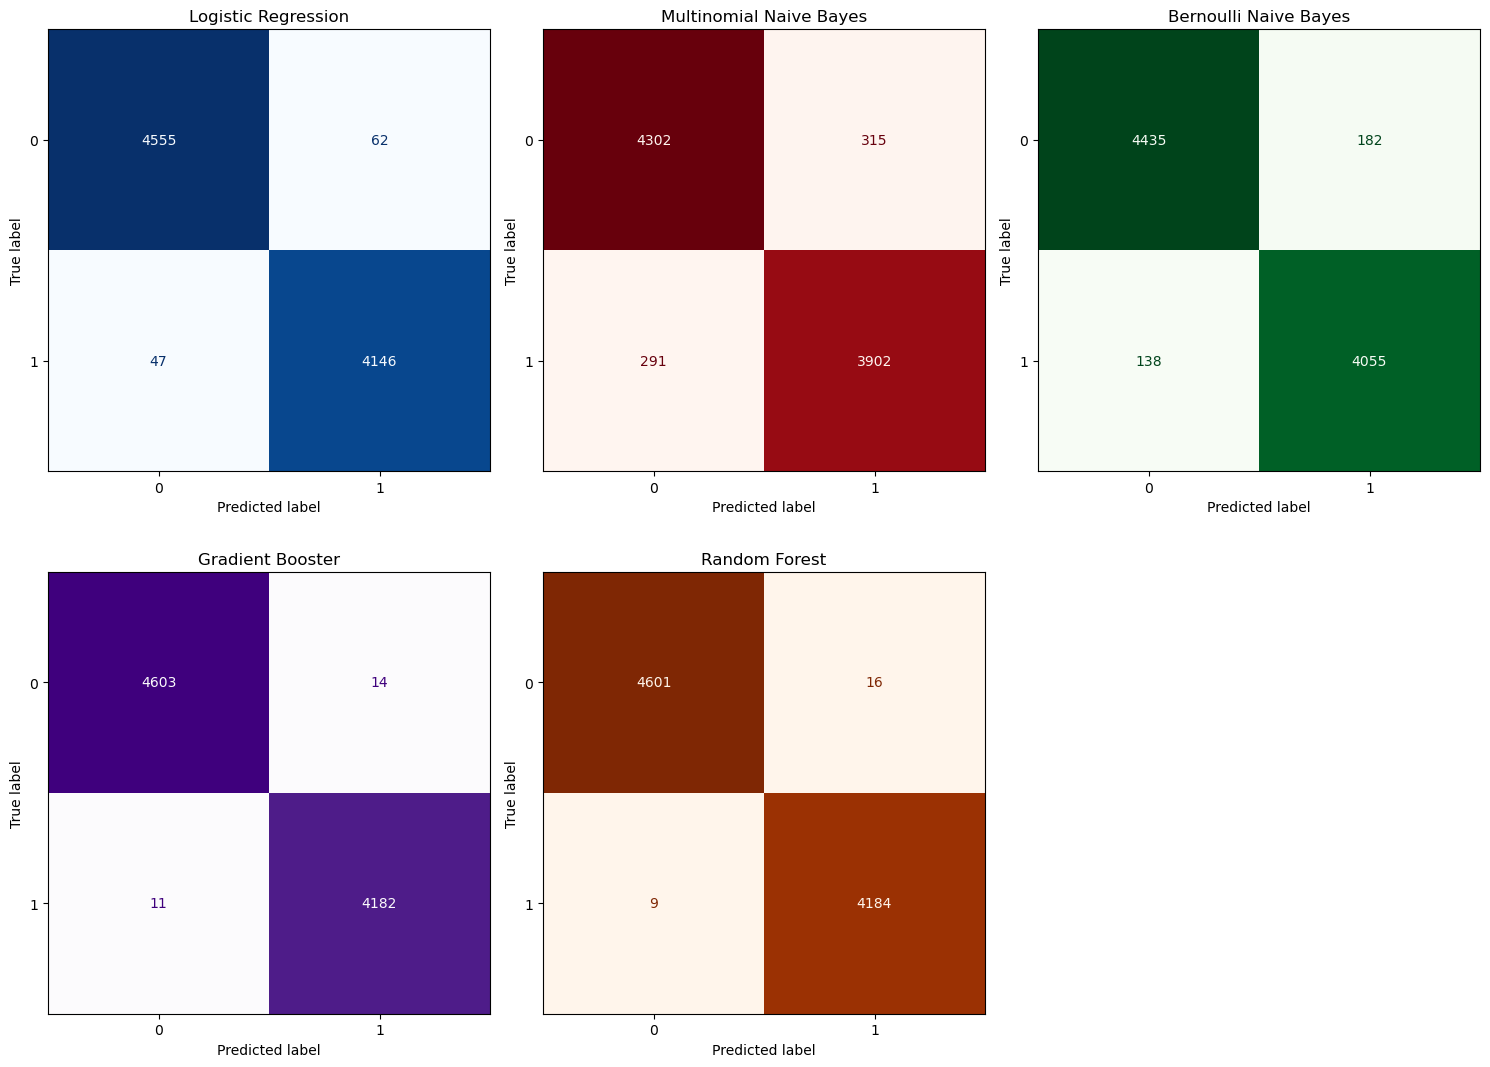

In [41]:
confusion_matrices = [
    (confusion_matrix(Y_test, y_pred_reg), "Logistic Regression", plt.cm.Blues),
    (confusion_matrix(Y_test, y_pred_mnb), "Multinomial Naive Bayes", plt.cm.Reds),
    (confusion_matrix(Y_test, y_pred_bnb), "Bernoulli Naive Bayes", plt.cm.Greens),
    (confusion_matrix(Y_test, y_pred_gb), "Gradient Booster", plt.cm.Purples),
    (confusion_matrix(Y_test, y_pred_rf), "Random Forest", plt.cm.Oranges)
]

fig, axes = plt.subplots(2, 3, figsize=(15, 11))

for i, (matrix, title, cmap) in enumerate(confusion_matrices):
    row, col = divmod(i, 3)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1])
    disp.plot(cmap=cmap, ax=axes[row, col], colorbar=False)
    axes[row, col].set_title(title)

if len(confusion_matrices) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


- After Comparing multiple ML models it seems the gradient booster ad random forest has the best accuracies
- Lets explore the hyper parameters of both by using gridsaerch to reach our conclusion model and create the pipline

## Random Forest Grid Search

In [58]:
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100,random_state=45)
rf.fit(X_train_tfidf, Y_train)

RandomForestClassifier(min_samples_split=5, random_state=45)

In [59]:
y_pred_rf= rf.predict(X_test_tfidf)
print(classification_report(Y_test, y_pred_rf))
print("a-Accuracy Score:",accuracy_score(Y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4617
           1       1.00      1.00      1.00      4193

    accuracy                           1.00      8810
   macro avg       1.00      1.00      1.00      8810
weighted avg       1.00      1.00      1.00      8810

a-Accuracy Score: 0.9971623155505108


In [57]:
param_grid = {
    'n_estimators': [100, 200],            
    'max_depth': [10, 20, None],           
    'min_samples_split': [2, 5],             
    'min_samples_leaf': [1, 2],              
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2   
)

grid_search.fit(X_train_tfidf, Y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


## HistGradientBoostingClassifier Grid Search

In [42]:
param_grid_gb={
    'learning_rate': [0.01, 0.05], 
    'max_iter': [200, 500],          
    'max_depth': [3, 5, None],            
    'max_leaf_nodes': [15, 31],   
    'min_samples_leaf': [10, 20],   
}
# gridSearch(HistGradientBoostingClassifier(), param_grid_gb, X_train_tfidf.toarray(),Y_train)
gb = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=500, random_state=45)
gb.fit(X_train_tfidf.toarray(), Y_train)

HistGradientBoostingClassifier(learning_rate=0.05, max_iter=500,
                               random_state=45)

In [44]:
y_pred_test = gb.predict(X_test_tfidf.toarray())
y_pred_train = gb.predict(X_train_tfidf.toarray())
Report(gb ,Y_train,y_pred_train, Y_test,y_pred_test)

Classification Report For HistGradientBoostingClassifier(learning_rate=0.05, max_iter=500,
                               random_state=45):
1-For Train Data:
a-Accuracy Score: 0.9998013508144616
b-MSE:  0.0001986491855383393
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18221
           1       1.00      1.00      1.00     17017

    accuracy                           1.00     35238
   macro avg       1.00      1.00      1.00     35238
weighted avg       1.00      1.00      1.00     35238

---------------------
2-For Test Data:
a-Accuracy Score: 0.9972758229284904
b-MSE:  0.002724177071509648
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4617
           1       1.00      1.00      1.00      4193

    accuracy                           1.00      8810
   macro avg       1.00      1.00      1.00      8810
weighted avg       1.00      1.00      1.00      8810



In [45]:
test_data= pd.read_csv("WELFake_Dataset.csv", sep= ",")
test_data.head(5)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [59]:
test_data.shape

(72095, 2)

In [49]:
test_data = test_data.drop(['Unnamed: 0','title'], axis=1)
test_data.head(5)

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [50]:
test_data.isnull().sum()

text     39
label     0
dtype: int64

In [52]:
test_data = test_data.dropna()
test_data.isnull().sum()

text     0
label    0
dtype: int64

In [54]:
test_data['text'] = test_data['text'].apply(clean_text)

In [55]:
test_data.head(5)

,text,label
0,comment expected barack obama member fyf fukyo...,1
1,post vote hillary already,1
2,demonstrator gathered last night exercising co...,1
3,dozen politically active pastor came private d...,0
4,r sarmat missile dubbed satan replace s fly mi...,1


In [56]:
new_test = test_data['text']
new_label = test_data['label']

In [57]:
new_test_tfidf = vectorizer.transform(new_test)

In [58]:
y_pred_test = gb.predict(new_test_tfidf.toarray())
print(classification_report(new_label, y_pred_test))
print("a-Accuracy Score:",accuracy_score(new_label, y_pred_test))

              precision    recall  f1-score   support

           0       0.27      0.38      0.31     35028
           1       0.01      0.01      0.01     37067

    accuracy                           0.19     72095
   macro avg       0.14      0.19      0.16     72095
weighted avg       0.14      0.19      0.16     72095

a-Accuracy Score: 0.1897080241348221


- Creating the pipline using Gradient booster

## Pipline For UI

In [74]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [clean_text(x) for x in X]
        
class ToDense(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()


In [75]:
pipeline = Pipeline([
    ('clean_text', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('to_dense', ToDense()),
    ('classifier', HistGradientBoostingClassifier(learning_rate=0.05, max_iter=500, random_state=45))
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

print("a-Accuracy Score:",accuracy_score(Y_test, y_pred))

a-Accuracy Score: 0.9971623155505108


In [77]:
joblib.dump(pipeline, 'news_classification_pipeline.pkl')

['news_classification_pipeline.pkl']